In [90]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter

from qiskit_aer.noise import NoiseModel, depolarizing_error

import matplotlib.pyplot as plt

# Task 2: Noise, Noise, and More Noise

## Part 1 & 2: Noise Model and Gate Basis
The preparation of the noise model and transpiling of the circuit using a set of basis gates are handled by the function `prepare_noise_simulation()`. The simulator takes in `basis_gates=['cx','id','rz','sx','x']` by default and runs $2024$ repetitions for each experiment. The gates `rz, sx, x` are followed by a one-qubit depolarizing channel of rate $\alpha$, and every gate `cx` is followed by a two-qubit depolarizing channel of rate $\beta$. The function also transforms a general quantum circuit so that it is compatible with the basis gates of the simulator.

In [91]:
def prepare_noise_simulation(circuit:QuantumCircuit, alpha:float, beta:float,           
                             basis_gates=['cx','id','rz','sx','x']):
    '''
    Transpile a quantum circuit using a set of basis gates
    and prepare the simulator that simulates the noisy version of the gates.
    
    :param circuit: General qiskit QuantumCircuit object
    :param alpha: Error rate of one-qubit gates
    :param beta: Error rate of two-qubit gates
    :param basis_gates: Set of basic gates composing the simulated circuit
    :return: 
        :transpile: the circuit to be simulated
        :noisy_simulator: the simulator of a noisy circuit
    '''
    
    # # Create noise model
    noise_model = NoiseModel(basis_gates=basis_gates)
    single_qubit_error = depolarizing_error(alpha, 1)
    two_qubit_error = depolarizing_error(beta, 2)
    noise_model.add_all_qubit_quantum_error(single_qubit_error, ['rz','sx','x'])
    noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    # Noise generator
    noisy_simulator = AerSimulator(noise_model=noise_model, shots=2048)
    
    # Transpile circuit for noisy basis gates
    transpiled = transpile(circuit, noisy_simulator)

    return transpiled, noisy_simulator

## Part 3: Adding two numbers with a quantum computer

The QFT adder for two integers [arxiv.org/abs/1411.5949] was implemented, which composes of a QFT subcircuit, its inverse, and some controlled phase gates that perform the addition-on-the-phase.

The main function `quantum_sum(a,b,approximation_degree)` includes every subcircuit and computes $a+b$. The parameter `approximation_degree` $N$ controls the strength of controlled phase gates $\mathrm{CPhase}(\lambda)=\mathrm{diag}(1,1,1,e^{i\lambda})$, in which the circuit prunes out gates with $\lambda > \frac{2\pi}{2^{N+1}}$ in the QFT and the addition-on-the-phase subcircuits.

The function `simulate()` executes the circuit to get a distribution of measurement outcomes, from which the function `accuracy()` computes the accuracy of the operation given the ground truth solution.


In [92]:
def qft(num_qubits:int, approximation_degree:int=None):
    '''
    Create the Quantum Fourier Transform circuit without the final bit reverse.
    :param num_qubits: Number of qubits the QFT acts on
    :param approximation_degree: The degree of approximation on controlled-phase gates
    :return: QFT circuit
    '''
    
    # Following qiskit convention, the last qubit stores the most-significant bit.
    qft_circuit = QuantumCircuit(num_qubits, name='QFT')
    for i in range(num_qubits-1,-1,-1):
        qft_circuit.h(qubit=i)
        for j in range(i-1,-1,-1):
            if approximation_degree is not None and i-j>approximation_degree:
                break                      
            theta = 2*np.pi / 2**(i-j+1)
            qft_circuit.cp(theta, control_qubit=j, target_qubit=i)
        qft_circuit.barrier()
    ## Reminder: NO SWAP
    return qft_circuit

def cz_bitstrings(length_a:int, length_b:int, approximation_degree:int=None):
    '''
    Create the quantum circuit that computes the addition of
    two unknown binary strings a and b in the phase basis.
    :param length_a: Length of the first binary string
    :param length_b: Length of the second binary string
    :param approximation_degree: The degree of approximation on controlled-phase gates
    :return: The addition circuit
    '''
    # Assume length_a <= length_b
    # Assume the digit order is an,...,...a1 and b1,b2,...,bm,
    # for a1 and b1 the most significant bits
    # because there is no bit reverse in our QFT circuit.
    
    assert length_a <= length_b 
    
    cz_circuit = QuantumCircuit(length_a + length_b, name='C.Phase')

    for i in range(length_a):
        for j in range(i, length_b):
            if approximation_degree is not None and j-i>approximation_degree:
                break
            theta = 2*np.pi / 2**(j-i+1)
            cz_circuit.cp(theta, control_qubit=i, target_qubit=length_a+j)
        cz_circuit.barrier()
                
    return cz_circuit

def quantum_sum(a:int, b:int, approximation_degree:int=None):
    '''
    Create the quantum circuit that computes a+b
    :param a: first integer
    :param b: second integer
    :param is_modular: whether the addition is modular 2**N, where N is the length of the bitstring of the larger number.
    :param approximation_degree: the approximation degree involved in the QFT and the addition
    :return: The quantum circuit for addition
    '''
    
    a_str = bin(a)[2:]
    b_str = bin(b)[2:]
    
    num_bits = max(len(a_str), len(b_str))
    a_str = a_str.zfill(num_bits)
    b_str = b_str.zfill(num_bits)
    
    num_qubits = 2*num_bits + 1 # Extra bit is the carry bit
    num_readouts = num_bits + 1 # Extra bit is the carry bit
    
    # Create the components
    qft_circ = qft(num_readouts, approximation_degree)
    iqft_circ = qft_circ.inverse()
    cz_circ = cz_bitstrings(num_bits, num_readouts, approximation_degree)
    
    # Encode the bitstrings to be added.
    circuit = QuantumCircuit(num_qubits, num_readouts, name='adder')
    for i in range(num_bits):
        if a_str[-i-1]  == '1':
            circuit.x(i)
        if b_str[-i-1] == '1':
            circuit.x(num_bits+i)
    circuit.barrier(label='init')
    
    # Apply QFT, addition and inverse QFT
    circuit.append(qft_circ, range(num_bits, num_qubits))
    circuit.barrier()
    circuit.append(cz_circ, range(num_qubits))
    circuit.append(iqft_circ, range(num_bits, num_qubits))
    circuit.barrier()
    
    # Measure
    circuit.measure(range(num_bits,num_qubits), range(num_readouts))
    
    return circuit

In [93]:
def simulate(circuit:QuantumCircuit, alpha:float, beta:float):
    transpiled_circuit, sim_noise = prepare_noise_simulation(circuit, alpha, beta)
    result = sim_noise.run(transpiled_circuit).result()
    counts_bin = result.get_counts(transpiled_circuit)
    counts_dec = {int(key, 2):val for key,val in counts_bin.items()}
    return counts_dec
    
def accuracy(count_dict:dict, exact_res:int):
    if exact_res in count_dict:
        return count_dict[exact_res] / sum(count_dict.values())
    else:
        return 0

In [94]:
# Simple test
circuit = quantum_sum(a=220, b=581)
count_dict = simulate(circuit, alpha=0., beta=0.)
count_dict

{801: 2048}

## Part 4: Effects of noise on quantum addition
We analyze the effect of noise by running the circuit for various noise strengths $\alpha, \beta$ from $10^{-5}$ to $10^{-3}$. Particularly, for a given pair of noise strengths, we compute the mean error rate for the addition of two random numbers in the range $[0,15]$. Note that this simulator allows the numbers to be as large as $2^{14}-1$, but we keep it small so that we can try out various noise strengths in a reasonable time.

It is clear from the final plot that increasing either $\alpha$ or $\beta$ will increase the error rate of the results obtained from the circuit. We notice that the circuit contains many controlled phase gates, so one way to mitigate the effect of noise is to cut down on the number of such gates. We compare the original circuit with the another circuit with `approximation_degree=3`. Since the input numbers use at most $4$ bits, the effectiveness of this measure is not clear. But we can see from the strong-noise regime that the approximate circuit provide an answer as accurate as the original circuit does. This is due to because the noise become strong enough to obscure the effect of weak phase gates. We expect this approximation will be more helpful when dealing with larger numbers.

The number of gates in the post-transpile circuit is very important as it determines how much noise would be in the simulation. Especially in our case, we heavily rely on $\mathrm{CPhase}$ gates that are present in every subcircuit of the main circuit. Apart from reducing such gates as we did using `approximation_degree`, we should also take care how a sequence of such gates get transpiled into. Qiskit built-in transpiler transpiles the gate $\mathrm{CPhase}(\lambda)$ into
$$(I \otimes \mathrm{R_Z}(\lambda/2)) \cdot \mathrm{CX} \cdot (I \otimes \mathrm{R_Z}(-\lambda/2)) \cdot \mathrm{CX} \cdot (\mathrm{R_Z}(\lambda/2) \otimes I)$$
It is possible to strategically order the $\mathrm{CPhase}$ gates in the subcircuits to reduce the number of $CX$ and $R_Z$ gates being used in the simulation by a considerable number. This also marks an interesting as the QFT and the QFT-based adder are very common subroutines in quantum algorithm.



In [95]:
alpha_range = np.logspace(-5,-3,num=10,base=10)
beta_range = np.logspace(-5,-3,num=10,base=10)
alphas, betas = np.meshgrid(alpha_range, beta_range)

num_bits = 4
int_range = 2**num_bits

num_additions = 10

approximation_degree = 3

avg_accuracy = []
avg_accuracy_approx = []

for alpha, beta in zip(alphas.ravel(), betas.ravel()):
    accuracy_list = []
    accuracy_approx_list = []
    
    for _ in range(num_additions):
        a_int = np.random.randint(int_range)
        b_int = np.random.randint(int_range)
        exact_sum = a_int + b_int
    
        ## Accuracy of full quantum_sum circuits
        circuit = quantum_sum(a_int, b_int, approximation_degree=None)
        count_dict = simulate(circuit, alpha, beta)
        accuracy_list.append(accuracy(count_dict, exact_res=exact_sum))
        
        ## Accuracy of approximate quantum_sum circuits with CRZ of small angles pruned.
        circuit_approx = quantum_sum(a_int, b_int, approximation_degree=approximation_degree)
        count_dict = simulate(circuit_approx, alpha, beta)
        accuracy_approx_list.append(accuracy(count_dict, exact_res=exact_sum))
        
    avg_accuracy.append(np.mean(accuracy_list))
    avg_accuracy_approx.append(np.mean(accuracy_approx_list))
    
    print('alpha = {}, beta = {}'.format(np.round(alpha,5), np.round(beta,5)))
    print('Accuracy without approximation = {}'.format(avg_accuracy[-1]))
    print('Accuracy with degree {} approximation = {}'.format(approximation_degree,
                                                          avg_accuracy_approx[-1]))
    print()

avg_accuracy = np.array(avg_accuracy).reshape(alphas.shape)
avg_accuracy_approx = np.array(avg_accuracy_approx).reshape(alphas.shape)
# print(avg_accuracy)
# print(avg_accuracy_approx)


alpha = 1e-05, beta = 1e-05
Accuracy without approximation = 0.999072265625
Accuracy with degree 3 approximation = 0.988232421875

alpha = 2e-05, beta = 1e-05
Accuracy without approximation = 0.9986328125
Accuracy with degree 3 approximation = 0.987060546875

alpha = 3e-05, beta = 1e-05
Accuracy without approximation = 0.998291015625
Accuracy with degree 3 approximation = 0.99423828125

alpha = 5e-05, beta = 1e-05
Accuracy without approximation = 0.99716796875
Accuracy with degree 3 approximation = 0.989892578125

alpha = 8e-05, beta = 1e-05
Accuracy without approximation = 0.995458984375
Accuracy with degree 3 approximation = 0.98154296875

alpha = 0.00013, beta = 1e-05
Accuracy without approximation = 0.992724609375
Accuracy with degree 3 approximation = 0.984326171875

alpha = 0.00022, beta = 1e-05
Accuracy without approximation = 0.9880859375
Accuracy with degree 3 approximation = 0.990185546875

alpha = 0.00036, beta = 1e-05
Accuracy without approximation = 0.984130859375
Accuracy

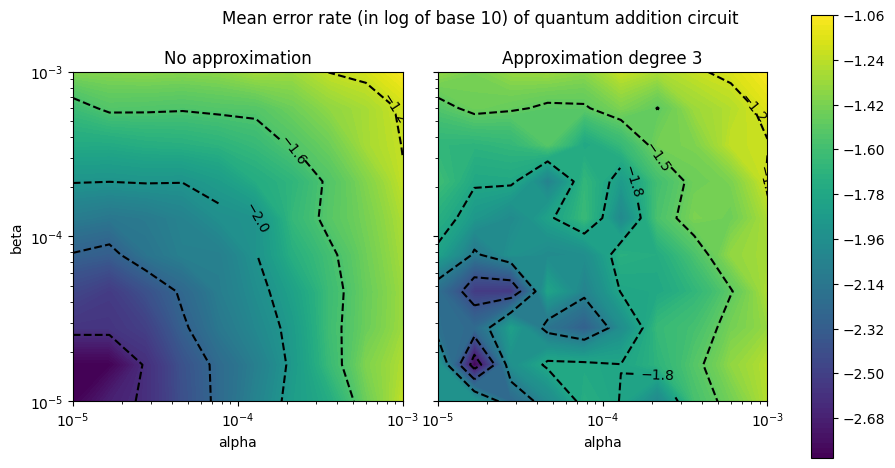

In [98]:
error_rate = 1 - avg_accuracy
error_rate_approx = 1 - avg_accuracy_approx


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),sharex='col', sharey='row')

ctr1 = ax1.contour(alphas, betas, np.log10(error_rate), levels=5, colors='k')
ax1.clabel(ctr1)
fil1 = ax1.contourf(alphas, betas, np.log10(error_rate), levels=100)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_aspect('equal')

ctr2 = ax2.contour(alphas, betas, np.log10(error_rate_approx), levels=5, colors='k')
ax2.clabel(ctr2)
fil2 = ax2.contourf(alphas, betas, np.log10(error_rate_approx), levels=100)
ax2.set_xlabel('alpha')
ax2.set_aspect('equal')

plt.tight_layout()
plt.colorbar(fil2, ax=(ax1,ax2))

ax1.axis('scaled')
ax2.axis('scaled')

ax1.set_xscale('log')
ax1.set_yscale('log')

ax2.set_xscale('log')
ax2.set_yscale('log')

ax1.set_title('No approximation')
ax2.set_title('Approximation degree {}'.format(approximation_degree))

fig.suptitle('Mean error rate (in log of base 10) of quantum addition circuit')

plt.show()

